Step 1: Import the necessary libraries


In [ ]:
import os
import shutil
import tarfile
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
import pandas as pd
from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objects as go
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


Step 2: Load the dataset


In [ ]:
# Get the current working directory
current_folder = os.getcwd()

dataset = tf.keras.utils.get_file(
	fname ="aclImdb.tar.gz",
	origin ="http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz",
	cache_dir= current_folder,
	extract = True)


84125825/84125825 [==============================] - 5s 0us/step


In [ ]:
dataset_path = os.path.dirname(dataset)
# Check the dataset
os.listdir(dataset_path)


['aclImdb', 'aclImdb.tar.gz']

In [ ]:
# Dataset directory
dataset_dir = os.path.join(dataset_path, 'aclImdb')

# Check the Dataset directory
os.listdir(dataset_dir)


['imdbEr.txt', 'imdb.vocab', 'test', 'train', 'README']

Check the ‘Train’ dataset folder


In [ ]:
train_dir = os.path.join(dataset_dir,'train')
os.listdir(train_dir)


['labeledBow.feat',
 'unsupBow.feat',
 'urls_unsup.txt',
 'unsup',
 'pos',
 'neg',
 'urls_neg.txt',
 'urls_pos.txt']

Read the files of the ‘Train’ directory files


In [ ]:
for file in os.listdir(train_dir):
	file_path = os.path.join(train_dir, file)
	# Check if it's a file (not a directory)
	if os.path.isfile(file_path):
		with open(file_path, 'r', encoding='utf-8') as f:
			first_value = f.readline().strip()
			print(f"{file}: {first_value}")
	else:
		print(f"{file}: {file_path}")


labeledBow.feat: 9 0:9 1:1 2:4 3:4 4:6 5:4 6:2 7:2 8:4 10:4 12:2 26:1 27:1 28:1 29:2 32:1 41:1 45:1 47:1 50:1 54:2 57:1 59:1 63:2 64:1 66:1 68:2 70:1 72:1 78:1 100:1 106:1 116:1 122:1 125:1 136:1 140:1 142:1 150:1 167:1 183:1 201:1 207:1 208:1 213:1 217:1 230:1 255:1 321:5 343:1 357:1 370:1 390:2 468:1 514:1 571:1 619:1 671:1 766:1 877:1 1057:1 1179:1 1192:1 1402:2 1416:1 1477:2 1940:1 1941:1 2096:1 2243:1 2285:1 2379:1 2934:1 2938:1 3520:1 3647:1 4938:1 5138:4 5715:1 5726:1 5731:1 5812:1 8319:1 8567:1 10480:1 14239:1 20604:1 22409:4 24551:1 47304:1
unsupBow.feat: 0 0:8 1:6 3:5 4:2 5:1 7:1 8:5 9:2 10:1 11:2 13:3 16:1 17:1 18:1 19:1 22:3 24:1 26:3 28:1 30:1 31:1 35:2 36:1 39:2 40:1 41:2 46:2 47:1 48:1 52:1 63:1 67:1 68:1 74:1 81:1 83:1 87:1 104:1 105:1 112:1 117:1 131:1 151:1 155:1 170:1 198:1 225:1 226:1 288:2 291:1 320:1 331:1 342:1 364:1 374:1 384:2 385:1 407:1 437:1 441:1 465:1 468:1 470:1 519:1 595:1 615:1 650:1 692:1 851:1 937:1 940:1 1100:1 1264:1 1297:1 1317:1 1514:1 1728:1 1793

Load the Movies reviews and convert them into the pandas’ data frame with their respective sentiment
Here 0 means Negative and 1 means Positive


In [ ]:
def load_dataset(directory):
	data = {"sentence": [], "sentiment": []}
	for file_name in os.listdir(directory):
		print(file_name)
		if file_name == 'pos':
			positive_dir = os.path.join(directory, file_name)
			for text_file in os.listdir(positive_dir):
				text = os.path.join(positive_dir, text_file)
				with open(text, "r", encoding="utf-8") as f:
					data["sentence"].append(f.read())
					data["sentiment"].append(1)
		elif file_name == 'neg':
			negative_dir = os.path.join(directory, file_name)
			for text_file in os.listdir(negative_dir):
				text = os.path.join(negative_dir, text_file)
				with open(text, "r", encoding="utf-8") as f:
					data["sentence"].append(f.read())
					data["sentiment"].append(0)

	return pd.DataFrame.from_dict(data)


Load the training datasets



In [ ]:
# Load the dataset from the train_dir
train_df = load_dataset(train_dir)
print(train_df.head())


Load the test dataset respectively


In [ ]:
test_dir = os.path.join(dataset_dir,'test')

# Load the dataset from the train_dir
test_df = load_dataset(test_dir)
print(test_df.head())


neg
urls_pos.txt
labeledBow.feat
urls_neg.txt
pos
                                            sentence  sentiment
0  *SPOILERS!* When I first saw the preview for t...          0
1  Although a well produced made for television m...          0
2  Possibly the worst film within the genre in ex...          0
3  "Riders of Destiny" was the first of several w...          0
4  Let's Get Tough is one of those movies that pe...          0


Step 3: Preprocessing


In [ ]:
sentiment_counts = train_df['sentiment'].value_counts()

fig =px.bar(x= {0:'Negative',1:'Positive'},
			y= sentiment_counts.values,
			color=sentiment_counts.index,
			color_discrete_sequence = px.colors.qualitative.Dark24,
			title='<b>Sentiments Counts')

fig.update_layout(title='Sentiments Counts',
				xaxis_title='Sentiment',
				yaxis_title='Counts',
				template='plotly_dark')

# Show the bar chart
fig.show()
pyo.plot(fig, filename = 'Sentiments Counts.html', auto_open = True)


'Sentiments Counts.html'

Text Cleaning


In [ ]:
def text_cleaning(text):
	soup = BeautifulSoup(text, "html.parser")
	text = re.sub(r'\[[^]]*\]', '', soup.get_text())
	pattern = r"[^a-zA-Z0-9\s,']"
	text = re.sub(pattern, '', text)
	return text


Apply text_cleaning



In [ ]:
# Train dataset
train_df['Cleaned_sentence'] = train_df['sentence'].apply(text_cleaning).tolist()
# Test dataset
test_df['Cleaned_sentence'] = test_df['sentence'].apply(text_cleaning)


<ipython-input-11-2374454d2258>:2: MarkupResemblesLocatorWarning:

The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.

<ipython-input-11-2374454d2258>:2: MarkupResemblesLocatorWarning:

The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.



Plot reviews on WordCLouds


In [ ]:
# Function to generate word cloud
def generate_wordcloud(text,Title):
	all_text = " ".join(text)
	wordcloud = WordCloud(width=800,
						height=400,
						stopwords=set(STOPWORDS),
						background_color='black').generate(all_text)
	plt.figure(figsize=(10, 5))
	plt.imshow(wordcloud, interpolation='bilinear')
	plt.axis("off")
	plt.title(Title)
	plt.show()


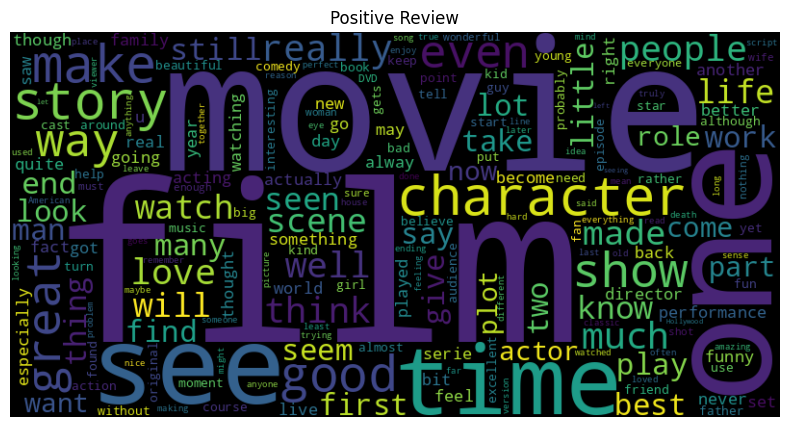

In [ ]:
positive = train_df[train_df['sentiment']==1]['Cleaned_sentence'].tolist()
generate_wordcloud(positive,'Positive Review')


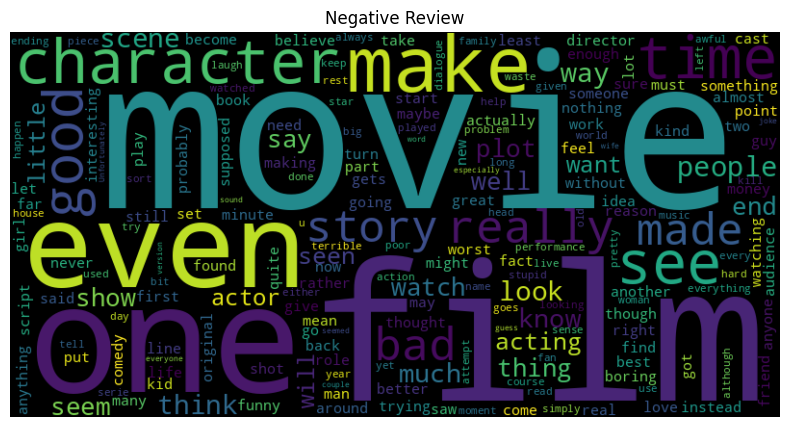

In [ ]:
negative = train_df[train_df['sentiment']==0]['Cleaned_sentence'].tolist()
generate_wordcloud(negative,'Negative Review')


Separate input text and target sentiment of both train and test



In [ ]:
# Training data
#Reviews = "[CLS] " +train_df['Cleaned_sentence'] + "[SEP]"
Reviews = train_df['Cleaned_sentence']
Target = train_df['sentiment']

# Test data
#test_reviews = "[CLS] " +test_df['Cleaned_sentence'] + "[SEP]"
test_reviews = test_df['Cleaned_sentence']
test_targets = test_df['sentiment']


Split TEST data into test and validation


In [ ]:
x_val, x_test, y_val, y_test = train_test_split(test_reviews,
													test_targets,
													test_size=0.5,
													stratify = test_targets)


Step 4: Tokenization & Encoding


Load the pre-trained BERT tokenizer


In [ ]:
#Tokenize and encode the data using the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Apply the BERT tokenization in training, testing and validation dataset


In [ ]:
max_len= 128
# Tokenize and encode the sentences
X_train_encoded = tokenizer.batch_encode_plus(Reviews.tolist(),
											padding=True,
											truncation=True,
											max_length = max_len,
											return_tensors='tf')

X_val_encoded = tokenizer.batch_encode_plus(x_val.tolist(),
											padding=True,
											truncation=True,
											max_length = max_len,
											return_tensors='tf')

X_test_encoded = tokenizer.batch_encode_plus(x_test.tolist(),
											padding=True,
											truncation=True,
											max_length = max_len,
											return_tensors='tf')


Check the encoded dataset


In [ ]:
k = 0
print('Training Comments -->>',Reviews[k])
print('\nInput Ids -->>\n',X_train_encoded['input_ids'][k])
print('\nDecoded Ids -->>\n',tokenizer.decode(X_train_encoded['input_ids'][k]))
print('\nAttention Mask -->>\n',X_train_encoded['attention_mask'][k])
print('\nLabels -->>',Target[k])


Training Comments -->> This 1919 to 1933 Germany looks hardly like a post WWII Czech capitol Oh sorry, it is the Czech capitol and it is 2003, how funnyThis is one of the most awful history movies in the nearest past Rhm is a head higher than Adolf and looks so damned good, Gring looks like 40 when he just is 23 and the Fhrer always seems to look like 56 And the buildings, folks, even buildings have been young, sometimes Especially 1919 were a lot of houses in Germany nearly new the WWI does not reach German cities No crumbling plaster Then the Reichstagsbuilding There have never been urban canyons around this building, never And this may sound to you all like a miracle in the year 1933 the Greater Berlin fire brigade owns a lot of vehicles with engines, some even with turntable ladders, but none with a hand pumpOne last thing What kind of PLAYMOBIL castle was this at the final sequence For me this was a kind of Adolf's Adventures in Wonderland

Input Ids -->>
 tf.Tensor(
[  101  2023 

Step 5: Build the classification model


In [ ]:
# Intialize the model
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Compile the model


In [ ]:
# Compile the model with an appropriate optimizer, loss function, and metrics
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])


Train the model


In [ ]:
# Step 5: Train the model
history = model.fit(
	[X_train_encoded['input_ids'], X_train_encoded['token_type_ids'], X_train_encoded['attention_mask']],
	Target,
	validation_data=(
	[X_val_encoded['input_ids'], X_val_encoded['token_type_ids'], X_val_encoded['attention_mask']],y_val),
	batch_size=32,
	epochs=3
)


Epoch 1/3
782/782 [==============================] - 796s 958ms/step - loss: 0.3347 - accuracy: 0.8510 - val_loss: 0.2739 - val_accuracy: 0.8854
Epoch 2/3
782/782 [==============================] - 785s 1s/step - loss: 0.1911 - accuracy: 0.9256 - val_loss: 0.2855 - val_accuracy: 0.8839
Epoch 3/3
782/782 [==============================] - 786s 1s/step - loss: 0.0947 - accuracy: 0.9667 - val_loss: 0.3232 - val_accuracy: 0.8864


Step 6:Evaluate the model


In [ ]:
#Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(
	[X_test_encoded['input_ids'], X_test_encoded['token_type_ids'], X_test_encoded['attention_mask']],
	y_test
)
print(f'Test loss: {test_loss}, Test accuracy: {test_accuracy}')


391/391 [==============================] - 110s 281ms/step - loss: 0.3206 - accuracy: 0.8896
Test loss: 0.32064133882522583, Test accuracy: 0.8895999789237976


Save the model and tokenizer to the local folder


In [ ]:
path = 'path-to-save'
# Save tokenizer
tokenizer.save_pretrained(path +'/Tokenizer')

# Save model
model.save_pretrained(path +'/Model')


Load the model and tokenizer from the local folder


In [ ]:
# Load tokenizer
bert_tokenizer = BertTokenizer.from_pretrained(path +'/Tokenizer')

# Load model
bert_model = TFBertForSequenceClassification.from_pretrained(path +'/Model')


Some layers from the model checkpoint at path-to-save/Model were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at path-to-save/Model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


Predict the sentiment of the test dataset


In [ ]:
pred = bert_model.predict(
	[X_test_encoded['input_ids'], X_test_encoded['token_type_ids'], X_test_encoded['attention_mask']])

# pred is of type TFSequenceClassifierOutput
logits = pred.logits

# Use argmax along the appropriate axis to get the predicted labels
pred_labels = tf.argmax(logits, axis=1)

# Convert the predicted labels to a NumPy array
pred_labels = pred_labels.numpy()

label = {
	1: 'positive',
	0: 'Negative'
}

# Map the predicted labels to their corresponding strings using the label dictionary
pred_labels = [label[i] for i in pred_labels]
Actual = [label[i] for i in y_test]

print('Predicted Label :', pred_labels[:10])
print('Actual Label :', Actual[:10])


391/391 [==============================] - 111s 276ms/step
Predicted Label : ['positive', 'Negative', 'positive', 'positive', 'positive', 'Negative', 'positive', 'Negative', 'positive', 'positive']
Actual Label : ['positive', 'Negative', 'positive', 'positive', 'positive', 'Negative', 'positive', 'Negative', 'Negative', 'positive']


Classification Report


In [ ]:
print("Classification Report: \n", classification_report(Actual, pred_labels))


Classification Report: 
               precision    recall  f1-score   support

    Negative       0.87      0.91      0.89      6250
    positive       0.91      0.87      0.89      6250

    accuracy                           0.89     12500
   macro avg       0.89      0.89      0.89     12500
weighted avg       0.89      0.89      0.89     12500



Step 7: Prediction with user inputs


In [ ]:
def Get_sentiment(Review, Tokenizer=bert_tokenizer, Model=bert_model):
	# Convert Review to a list if it's not already a list
	if not isinstance(Review, list):
		Review = [Review]

	Input_ids, Token_type_ids, Attention_mask = Tokenizer.batch_encode_plus(Review,
																			padding=True,
																			truncation=True,
																			max_length=128,
																			return_tensors='tf').values()
	prediction = Model.predict([Input_ids, Token_type_ids, Attention_mask])

	# Use argmax along the appropriate axis to get the predicted labels
	pred_labels = tf.argmax(prediction.logits, axis=1)

	# Convert the TensorFlow tensor to a NumPy array and then to a list to get the predicted sentiment labels
	pred_labels = [label[i] for i in pred_labels.numpy().tolist()]
	return pred_labels


Let’s predict with our own review


In [ ]:
Review ='''Bahubali is a blockbuster Indian movie that was released in 2015.
It is the first part of a two-part epic saga that tells the story of a legendary hero who fights for his kingdom and his love.
The movie has received rave reviews from critics and audiences alike for its stunning visuals,
spectacular action scenes, and captivating storyline.'''
Get_sentiment(Review)


1/1 [==============================] - 3s 3s/step


['positive']

In [ ]:
Review='The movie is not that great. It could be better but it absolutely was not. '
Get_sentiment(Review)

1/1 [==============================] - 0s 69ms/step


['Negative']